In [1]:
# !pip3 install scikit-image

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.metrics import structural_similarity
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from umap import UMAP
from warnings import filterwarnings

filterwarnings('ignore')

In [3]:
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

## Цветовая квантизация изображения с помощью кластеризации 
Будем решать следующую задачу: с помощью методов кластеризации уменьшим количество цветов изображения так, чтобы новое изображение было максимально визуально похоже на исходное. Эта задача без ограничения на метод решения носит название [цветовой квантизации изображения](https://en.wikipedia.org/wiki/Color_quantization). Это может быть применимо, например, для сжатия изображения.

В качестве примера изображения предлагается использовать файл `pesik.png`.

Размер картинки (403, 604, 3)


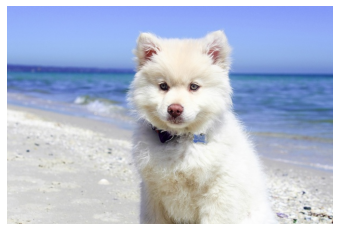

In [4]:
# Представление изображения в виде массива
img = plt.imread('pesik.jpg')
print("Размер картинки", img.shape)

# Визуализация массива
plt.imshow(img)
plt.axis('off');

**Идея** применения кластеризации в качестве метода решения задачи заключается в следующем. С одной точки зрения пиксели &mdash; это точки изображения имеющие пространственные координаты, содержащие информацию о цвете. А если посмотреть с другой стороны, то &mdash; это точки имеющие цветовые координаты, несущие информацию о местоположеннии в изображении. Следуя второй точке зрения, предположим, что пиксели разбиваются на $n$ кластеров в цветовом пространстве. Тогда пиксели лежащие в одном кластере будут ближе друг к другу по цвету, чем к другим пикселям. Таким образом, присвоив всем пикселям в одном кластере цвет, который наилучшим образом описывает кластер, можно получить изображение из $n$ цветов достаточно визуально близкое к исходному.  

### 1. Визуализация данных
Попробуем сначала визуализировать точки изображения в пространстве цветов. Это пространство 3-мерное, поэтому можно сделать 3 проекции на на каждую пару цветовых осей.

Избавимся от первых 2 размерностей

In [5]:
X = np.vstack(img)
X.shape

(243412, 3)

Визуализация

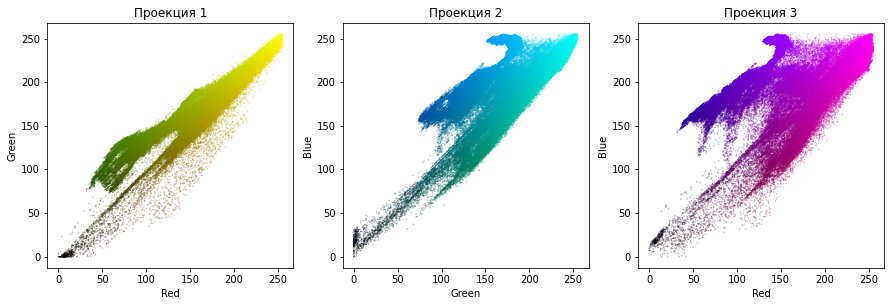

In [6]:
names = ['Red', 'Green', 'Blue']
plt.figure(figsize=(15, 4.5))

for i, (c1, c2) in enumerate(zip([0, 1, 0], [1, 2, 2])):
    axs = plt.subplot(1, 3, i+1)
    colors = np.zeros((3, X.shape[0]))
    colors[c1] = X[:, c1] / 255
    colors[c2] = X[:, c2] / 255
    plt.scatter(X[:, c1], X[:, c2], alpha=0.5, c=colors.T, s=0.1)
    plt.xlabel(names[c1])
    plt.ylabel(names[c2])
    plt.title('Проекция {}'.format(i+1))

> Видны ли кластеры? Сколько кластеров вы бы выделили?

Можно выделить 3-4 кластера.

Теперь понищим размреность данных.  
> Вспомните методы понижения размерности. Какие на ваш взгляд наиболее эффективные для визуализации кластеров в данных?  Требуют ли эти методы нормировку? Какой из этих методов работает быстрее? 

1. Среди методов понижения размерности наиболее эффективными для визуализации кластеров являются TSNE и UMAP. Они используют нелинейные преобразования и максимально сохраняют структуру данных.
2. TSNE и UMAP используют расстояние между точками. Поэтому данные нужно нормировать.
3. В силу архитетурв методов UMAP работает быстрее на больших данных.

Исходя из достоинтсв UMAP, перечисленных выше, будем использовать это метод.

In [7]:
X_umap = UMAP(n_components=2, n_neighbors=20).fit_transform(X)

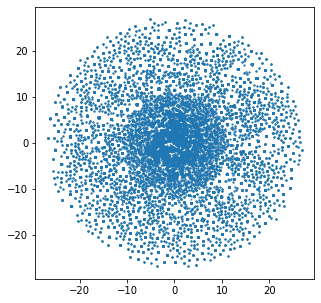

In [8]:
plt.figure(figsize=(5, 5))
plt.scatter(X_umap.T[0], X_umap.T[1], s=1, alpha=0.1);

> А теперь, видны ли кластеры? Сколько кластеров вы бы выделили?

### 2. Применение кластеризации  
  
> Вспомните методы кластеризации, которые могут разбивать данные на заданное число кластеров. Какова сложность этих методов? Требуют ли эти методы нормировки данных?

Перечислим методы кластеризации, которые могут разбивать данные на заданное число кластеров. Также запишем время работы методов в зависимости от $n$ &mdash; числа элементов в выборке, и определим, нужна ли нормировка.
* K-средних &mdash; $O(n)$, нормировка нужна.
* EM-алгоритм для гауссовской смеси &mdash; $O(n)$, нормировка не нужна.
* Спектральная кластеризация &mdash; $O(n^3)$, нормировка нужна.
* Аггломеративная кластеризация в общем случае &mdash; $O(n^3)$, нормировка нужна.

Выберем наиболее быстрые методы: *k-средних* и *EM-алгоритм для гауссовской смеси*. Разобьем изображение на $8$ кластеров.

In [9]:
n = 8
img_new = np.zeros((2, *img.shape), dtype=int)
labels = np.zeros((2, X.shape[0]), dtype=int)

Обучим k-means

In [10]:
k_means = KMeans(n_clusters=n)
k_means.fit(X)

labels[0] = k_means.labels_
values = k_means.cluster_centers_.squeeze().astype(int)
img_new[0] = np.array([values[labels[0][i]] for i in range(X.shape[0])]).reshape(img.shape)

Обучим EM-алгоритм

In [11]:
gauss_mix = GaussianMixture(n_components=n)
gauss_mix.fit(X)

labels[1] = gauss_mix.predict(X)
values = np.array([np.median(X[labels[1] == i], axis=0) for i in range(n)]).astype(int)
img_new[1] = np.array([values[labels[1][i]] for i in range(X.shape[0])]).reshape(img.shape)

Изобразим результаты кластеризации, используя UMAP.

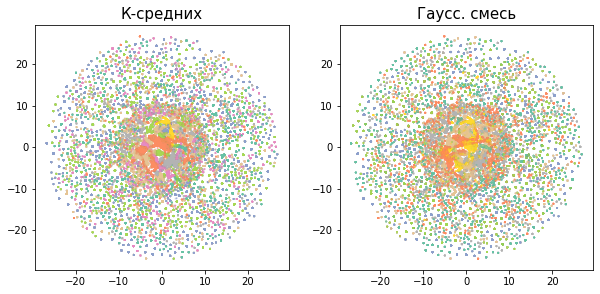

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5))
methods_names = ['К-средних', 'Гаусс. смесь']
labels_new = np.zeros_like(labels)
labels_new[0] = labels[0]

for i in range(n):
    mask0 = labels[0] == i
    label1 = np.median(labels[1][mask0])
    mask1 = labels[1] == label1
    labels_new[1][mask1] = i
    
for i, method_name in enumerate(methods_names):
    axs[i].scatter(X_umap.T[0], X_umap.T[1], s=1, alpha=0.1, c=labels_new[i], cmap='Set2')
    axs[i].set_title(method_name, fontsize=15)

Изобразим результаты кластеризации в виде изображений собаки.

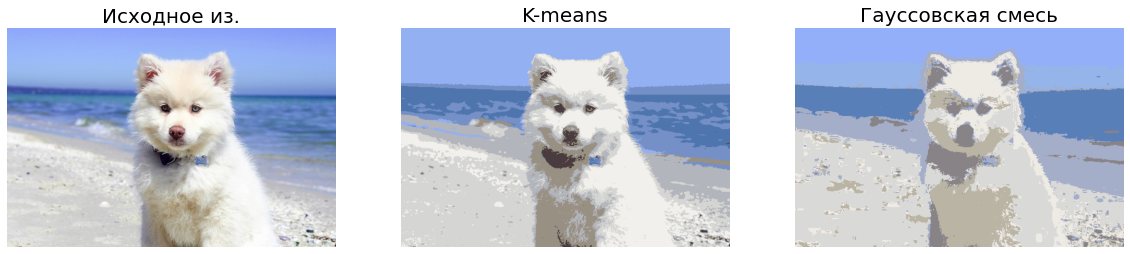

In [13]:
plt.figure(figsize=(20, 5))

# Исходное изображение
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title('Исходное из.', fontsize=20)
plt.axis('off');

# K-means
plt.subplot(1, 3, 2)
plt.imshow(img_new[0])
plt.title('K-means', fontsize=20)
plt.axis("off")

# Гауссовская смесь
plt.subplot(1, 3, 3)
plt.imshow(img_new[1])
plt.title('Гауссовская смесь', fontsize=20)
plt.axis("off");

> Какой метод показывает лучшие результаты?

Посчитаем метрику схожести изображений [SSIM](https://ru.wikipedia.org/wiki/SSIM), которая учитывает воспириятие изображения человеком.

In [14]:
# Пример
structural_similarity(img, img, multichannel=True)

1.0

In [15]:
ssim = np.zeros(2)
for i in range(3):
    ssim[0] = structural_similarity(img, img_new[0], multichannel=True)
    ssim[1] = structural_similarity(img, img_new[1], multichannel=True)
print('К-средних:', ssim[0])
print('Гаусс. смесь', ssim[1])

К-средних: 0.7901185554648925
Гаусс. смесь 0.6513402641939757


> Сходятся ли результаты с вашим восприятием полученных изображений? 

### 3. Качество сжатия в зависимости от числа кластеров   
  
 Выберем k-means и применим его к данным, задавая различное количество кластеров: 2, 4, 8, 16, ..., 256.


In [17]:
img_new = np.zeros((8, *img.shape), dtype=int)
labels = np.zeros((8, X.shape[0]), dtype=int)

for i in range(8):
    n = int(2 ** (i + 1))
    k_means = KMeans(n_clusters=n)
    k_means.fit(X)
    
    labels[i] = k_means.labels_
    values = k_means.cluster_centers_.squeeze().astype(int)
    img_new[i] = np.array([values[labels[i][j]] for j in range(X.shape[0])])\
        .reshape(img.shape)

Посмотрим на результаты

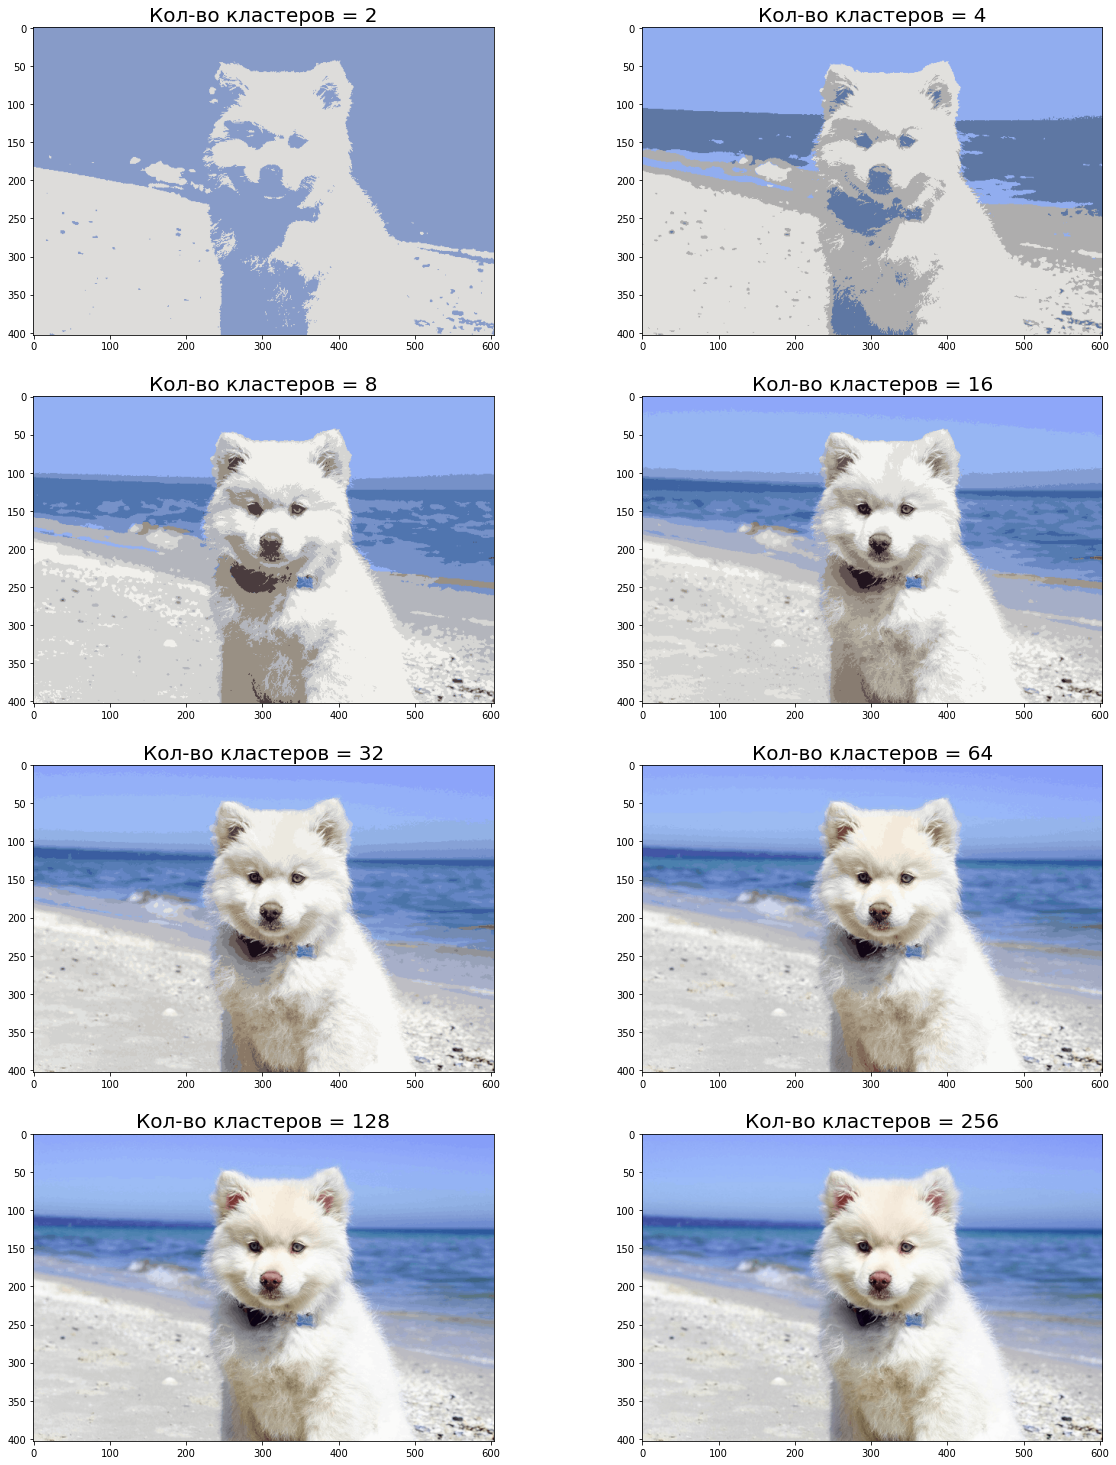

In [18]:
fig, axs = plt.subplots(4, 2, figsize=(20, 26))
for i in range(8):
    n = int(2 ** (i+1))
    axs[i//2, i%2].imshow(img_new[i])
    axs[i//2, i%2].set_title('Кол-во кластеров = {}'.format(n), fontsize=20)

Построим график метрики SSIM в зависимости от количества кластеров.

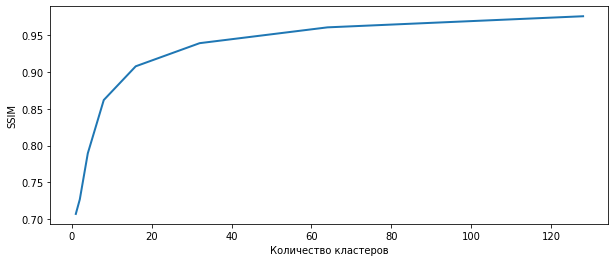

In [19]:
ssim = [structural_similarity(img, img_new[i], multichannel=True) for i in range(8)]

plt.figure(figsize=(10, 4))
plt.plot(2 ** np.arange(8), ssim, lw=2)
plt.xlabel('Количество кластеров')
plt.ylabel('SSIM');